# SMT (Satisfiability Modulo Theories) Practical Session

Practical session of Automated Verification Techniques (BMEVIMIMA29), 2024

by Csanád Telbisz, ftsrg (Critical Systems Research Group), Budapest University of Technology and Economics

## Overview

The purpose of this session is to get familiar with the ways problems can be modelled and solved using SMT solvers. We will use the Python APIs of the Z3 SMT solver(s) to model and solve problems, and we will also look at the SMT-LIB interface.

The first part of the notebook contains a brief overview of the Python SMT API with a lot of example code given. You will have to solve exercise with less and less help as you proceed. Look for *TODO*s in the code: you have to complete the solution at those points. If you have any technical questions or problems concerning the APIs, check the documentations and tutorials referenced at the end of this notebook. If you have any questions concerning the exercises, feel free to ask the tutors via Teams or email.

## Install Z3

In [3]:
!pip install z3-solver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 51.4 MB/s eta 0:00:00



### Required Imports

The required import for Z3 is:

In [4]:
from z3 import *

There is a bunch of SMT solvers with different advantages and disadvantages. Some of them also have a Python API which are even interchangeable with the Z3 API in some cases (e.g., the [cvc5 Python API](https://cvc5.github.io/docs/cvc5-1.1.2/api/python/python.html)). You may try other solvers if you like, but we will stick to Z3 in this session as one of the most widely used and stable SMT solvers.

# A Brief Overview of the Python SMT API

### Declaration of Various Kinds: Constants/Variables, Functions, etc.

One of the first steps when interfacing SMT solvers is to declare the types (sorts) and symbols needed for modelling.

Using Python, we can declare variables (or constants, if you prefer) using the sort name as a constructor, or using the `Const` constructor. As a convention, the solver variable is usually assigned to a Python variable of the same name, which is later used to construct expressions. The available sorts include the ones introduced in the various SMT-LIB theories. Bit-vector variables are declared by adding the bit-width as a second argument, and arrays by adding the index and object sorts (the index is typically Int sort in a conventional array).

In [6]:
# variables x, y ranging over the reals
x = Real('x')
y = Const('y', RealSort())

# variable z ranging over the integers
z = Int('z')

# boolean variable b
b = Bool('b')

# bit-vector variable bv, with bit-width 32
bv = BitVec('bv', 32)

# array variable a, with index and object sorts integer
a = Array('a', IntSort(), IntSort())

print(x)
print(bv.sort())

x
BitVec(32)


There are various short-hands available for declaring multiple variables simultaneously, which is often needed. It is often convenient to use Python list comprehension as part of declarations:

In [7]:
# three integer variables
a, b, c = Ints('a b c')

# a vector of 8 integer variables
vars = IntVector('vars', 8)

# a list of 10 bit-vector variables (each bit-vector is 32-bit long) declared by list comprehension
vars2 = [BitVec(f"vars2_{i}", 32) for i in range(10)]

print(vars[0])
print(vars2[0])

vars__0
vars2_0


Sorts are basically types. Functions are declared using the `Function` constructor, providing the argument and result sorts. We can also declare uninterpreted sorts using the `DeclareSort` constructor:

In [8]:
S = DeclareSort('S')
f = Function('f', BoolSort(), S, IntSort())

print(f)
print(f.arity())

f
2


## Constructing Expressions

### Quantifier-Free Expressions

After declaring the required vocabulary, terms and formulas can be built using "Pythonic" syntax by using mathematical/infix notation. The available operators correspond to those defined in SMT-LIB; for the details, we refer to the [section on theories](https://theory.stanford.edu/~nikolaj/programmingz3.html#sec-theories) in the _Programming Z3_ article.

For simple tasks, we can also use the function `solve` to check satisfiability of a formula, and compute a solution.

In [9]:
x, y = Reals('x y')

# a real-valued term
t = x + y
print(t)
print(t.sort())

# a conjunction of two equations
f = And(x == y + 1.5, y != 0)
print(f.decl())
print(f.children())

# compute a solution of the formula
solve(f)

# conjoining another inequality makes the formula unsat
solve(f, x < y)

x + y
Real
And
[x == y + 3/2, y != 0]
[y = -3/2, x = 0]
no solution


**Exercise 1** (0 points, required)

Invert the following real-valued matrix:
$$
A = \begin{pmatrix} 1 & 2 \\ 3 & 4 \end{pmatrix}
$$


In [11]:
M = [[1, 2],
     [3, 4]]

# declare four variables over the reals to represent the elements of the inverse matrix M^-1
# M^-1 = |a b|
#        |c d|

# TODO: YOUR SOLUTION HERE

a = Real('a')
b = Real('b')
c = Real('c')
d = Real('d')

# formulate four equations characterising the inverse, use the function solve
# (hint: formulate the matrix product M * M^-1 = I manually for each element of I)

# TODO: YOUR SOLUTION HERE

f = And(M[0][0] * a + M[0][1] * c == 1,
        M[0][0] * b + M[0][1] * d == 0,
        M[1][0] * a + M[1][1] * c == 0,
        M[1][0] * b + M[1][1] * d == 1)
solve(f)

[c = 3/2, a = -2, b = 1, d = -1/2]


### Quantified Formulas

For quantified formulas, we can use the `ForAll` or `Exists` constructors.

In [ ]:
x, y = Ints('x y')

# 18 is a composite number: there are two integers x, y bigger than 1 such that 18 = x * y
# sat: a solution exists (but no free variables occur in the formula, so the output is empty)
solve(Exists([x, y], And(18 == x*y, x > 1, y > 1)))

Two solutions for proving that not all integers are even:

In [ ]:
# there is an x such that x cannot be divided by 2 (no y exists such that x = 2*y)
# sat: any odd number is a good candidate for x
solve(Exists(x, Not(Exists(y, x == 2*y))))

# same as above, just negated: we try to prove that all integers are even and we fail
# unsat: because not all integers are even (no solution exists)
solve(ForAll(x, Exists(y, x == y*2)))

**Exercise 2** (0 points, required)

Prove that there is a bound `B` such that every integer `x >= B` can be expressed as a non-negative integer linear combination of 7 and 8. That is, there are non-negative integer constants `y` and `z` such that `x = y*7 + z*8` for each `x >= B`. What is the smallest `B` with this property?

FYI: the generalization of this problem is called the [Frobenius coin problem](https://en.wikipedia.org/wiki/Coin_problem).

Suggested steps:
* Formulate the problem as a quantified formula on paper first as you would do it in a math class.
* Declare the necessary variables first.
* Write the formulas in code.

In [29]:
# declare variables: x, y, z, B, Bmin (B for proving the existence of the bound, Bmin for finding the minimal bound)
# TODO: YOUR SOLUTION HERE

x = Int('x')
y = Int('y')
z = Int('z')
B = Int('B')
Bmin = Int('Bmin')

# formula proving the existence of such a bound
# TODO: YOUR SOLUTION HERE, something like: solve(Exists(B, ...))

f = ForAll(x, Implies(x >= B, Exists([y, z], And(y >= 0, z >= 0, x == 7 * y + 8 * z))))
solve(f)

# formula for finding the minimal bound
# TODO: YOUR SOLUTION HERE
for Bmin in range(50):
    solve(And(f,B == Bmin))



[B = 42]
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
no solution
[B = 42]
[B = 43]
[B = 44]
[B = 45]
[B = 46]
[B = 47]
[B = 48]
[B = 49]


### Uninterpreted functions

Uninterpreted functions are functions where only the signature is defined but the implementation or semantics is not. The solver tries to find an interpretation that matches the given formula - if it is possible. It is perfectly enough to prove some properties. Let us prove the following:

$\forall x. f(x) \geq 0 \Rightarrow f(42) > -10$

In plain words: if we know that outputs of $f$ are non-negative, then the output of $f$ for input 42 is greater than -10.

In [ ]:
# uninterpreted function defined by its signature: f: Int -> Int
f = Function('f', IntSort(), IntSort())

# we give the negation of our formula to the solver to make it find a counterexample violating our claim
# unsat: this implies that no counterexample exists, so the original formula holds
solve(
    Not(
        Implies(
            ForAll(x, f(x) >= 0),
            f(42) > -10
        )
    )
)

## The Solver API

For more complex modelling tasks, it is useful to instantiate a solver first which then offers an API similar to the SMT-LIB interface, including:
* `add`: add new constraints/assertions to the solver.
* `check`: check whether the given constraints are satisfiable.
* `model`: in case of satisfiable constraints, compute a model/satisfying assignment.

Solver check results: when using the `solve` method (as before), the result is either a model (`[x=2,...]`) or `no solution`. The `check` method returns `sat` (when there is a solution) or `unsat` (when the provided assertions are unsatisfiable). And of course, the final output may be some error message (e.g., failed to solve).

In [30]:
x, y = Ints('x y')
s = Solver()

s.add(x == 2*y + 1)
s.add(Implies(x >= 0, y >= 0))

print(s.check())
print(s.model())

sat
[y = 0, x = 1]


It is often necessary to analyse models returned by the solver. We can determine the value of expressions in a given model using the method `evaluate`:

In [31]:
m = s.model()
print(m.evaluate(x + y))

# determine variables defined by the model
print(m.decls())

# the following constraint "asks" for a different model: we iterate over the variables
# defined by the model (m.decls()), and we construct a disjunction stating that at least
# one of those variables should have a value different from the one in the model.
s.add(Or([ x() != m[x()] for x in m.decls() ]))
print(s.check())
print(s.model())

1
[y, x]
sat
[x = 3, y = 1]


The solver can be used incrementally as well. For this, the solver provides an _assertion stack_ to which constraints can be pushed and from which constraints can be removed. The following two methods are available to control the assertion stack:
* `push`: add a new scope on the assertion stack.
* `pop`: remove the top-most scope from the stack.

## A Brief Overview of SMT-LIB 2.6

SMT-LIB provides a standardized textual interface to SMT solvers. SMT-LIB scripts are designed to be easy to generate and easy to parse, but the format offers little syntactic sugar; when modelling problems by hand, SMT-LIB is therefore relatively tedious. It is possible, however, to model some of the easier problems also directly using SMT-LIB; or some day, you may have to implement a tool that communicates with an SMT solver using the SMT-LIB format.

If you would like to try SMT-LIB by hand, you have the following options to interact with SMT solvers:
* Play with a web application accepting SMT-LIB input: [Z3 playground](https://microsoft.github.io/z3guide/playground/Freeform%20Editing) or [cvc5](https://cvc5.github.io/app/)
* Parse SMT-LIB script from string using the Python API: `s.from_string("<your SMT-LIB script>")`

### Declarations

SMT-LIB is based on expressions which are written in prefix notation (e.g., `+ 3 4` instead of `3 + 4`). The standard mandates that every script starts with a `set-logic` command specifying the applied [logic](https://smt-lib.org/logics.shtml), e.g.:
```
(set-logic QF_LIA) ; quantifier-free linear integer problems
```
Technically, most of the time, SMT solvers are clever enough to infer the logic from the constraints, but it is good practice to specify it explicitly.

We declare sorts, variables and functions using the commands:
* `declare-sort` for declaring sorts,
* `declare-const` for declaring variables (aka constants),
* `declare-fun` for declaring functions.

```
(declare-sort S)
(declare-const x Real)
(declare-const y Int)
(declare-const bv (_ BitVec 32))
(declare-fun f (Bool S) Int)
```

### Constructing Assertions

Through SMT-LIB, solvers expose an interface similar to the one available with the Python `Solver` class. We can add new formulas using the command `assert` and control the assertion stack using commands `push` and `pop`. The latter two commands receive a numeric argument telling how many scopes are supposed to be pushed or popped. The status of the asserted formulas can be checked using the command `check-sat`, and a model be extracted using `get-model`.

All expressions have to be formulated using the signatures provided by the respective [SMT-LIB theories and logics](https://smt-lib.org/theories.shtml). Comments start with a semicolon `;`.

```
(set-logic QF_LIA)

(declare-const x Int)
(declare-const y Int)

; x == 2*y + 1
(assert (= x (+ (* 2 y) 1)))

; Implies(x >= 0, y >= 0)
(assert (=> (>= x 0) (>= y 0)))

(check-sat)
; sat
(get-model)
; (model
;   (define-fun y () Int (- 1))
;   (define-fun x () Int (- 1))
; )
```

# Basic Modelling Exercises

## Exercise 3: Alphametics (0.5 points)

Alphametics (aka cryptarithms) are arithmetic puzzles in which every letter has to be replaced by a digit, i.e., a number in the range `[0, 9]`, so that some equation is satisfied. We also require that the digits are pairwise distinct, and that the left-most digit of each term is non-zero. Alphametics can be solved easily using an SMT solver by declaring an appropriate set of variables, of sort `Int` or `BitVec`, adding the relevant constraints about digits, and stating the equation to be solved.

Solve this example:

```
  KNIFE
+  FORK
+ SPOON
+  SOUP
-------
 SUPPER
```

Hint: there is a `Distinct` operator (operator like `And` and `Not`) available in Z3 which states that its argument terms have pairwise distinct values. See [reference](https://z3prover.github.io/api/html/namespacez3py.html#aac3e33e977e8037611916937caffa78e).

In [41]:
# TODO: YOUR SOLUTION HERE

K, N, I, F, E, O, R, S, P, U = Ints('K, N, I, F, E, O, R, S, P, U')

s = Solver()

letters = [K, N, I, F, E, O, R, S, P, U]
s.add(Distinct(letters))
s.add(K != 0, F != 0, S != 0, S != 0)
s.add([letter >= 0 for letter in letters])
s.add([letter <= 9 for letter in letters])



s.add(10000 * K + 1000 * N + 100 * I + 10 * F + E +
      1000 * F + 100 * O + 10 * R + K +
      10000 * S + 1000 * P + 100 * O + 10 * O + N +
      1000 * S + 100 * O + 10 * U + P ==
      100000 * S + 10000 * U + 1000 * P + 100 * P + 10 * E + R
      )

print (s.check())
print (s.model())




sat
[I, = 7,
 R, = 3,
 P, = 5,
 E, = 6,
 N, = 4,
 F, = 2,
 U = 0,
 O, = 9,
 K, = 8,
 S, = 1]


## Exercise 4: Sudoku (0.5 points)

No SMT exercise would be complete without a Sudoku challenge. The constraints of Sudoku can be modelled using either integer or bit-vector variables, in both cases restricted to the range `[1, 9]`. An encoding with bit-vectors tends to be more efficient, since the SMT solver can translate the complete puzzle to a SAT problem. Take
[this Sudoku instance](https://en.wikipedia.org/wiki/Mathematics_of_Sudoku#/media/File:Oceans_Sudoku17_Puzzle-39451_trimmed.png), and solve it by encoding the puzzle and the constraints into SMT.

You might find the following bit-vector operators useful (as well as do not forget about the `Distinct` operator):

* `ULT`: unsigned less-than
* `ULE`: unsigned less-than-or-equal
* `UGT`: unsigned greater-than
* `UGE`: unsigned greater-than-or-equal

The conversion between integer literals and bit-vector happens automatically in the Python API.

For modelling an $N\times N$ Sudoku, we can start by creating a vector of $N\cdot N$ variables and use loops and list comprehension to add the necessary constraints:

In [72]:
s = Solver()

N = 9
B = 4  # 4-bit bit-vectors to represent numbers 1-9
entry = [BitVec(f"entry{i}", B) for i in range(N*N)]

# function to access entries using rows and columns
def e(row, col):
  return entry[row*N + col]

# fixed entries, the puzzle (referenced above) to be solved
s.add(And(e(0, 7)==1, e(1, 5)==2, e(1, 8)==3, e(2, 3)==4, e(3, 6)==5, e(4, 0)==4, e(4, 2)==1, e(4, 3)==6, e(5, 2)==7, e(5, 3)==1, e(6, 1)==5, e(6, 6)==2, e(7, 4)==8, e(7, 7)==4, e(8, 1)==3, e(8, 3)==9, e(8, 4)==1))

# constraints for Sudoku
# - all entries are between 1 and N
# - the entries in each row, column and sub-square are pairwise distinct

# TODO: YOUR CODE HERE
for i in range(N * N):
    s.add(And(UGE(entry[i], 1), ULE(entry[i], N)))

for row in range(N):
    s.add(Distinct([e(row, col) for col in range(N)]))

for col in range(N):
    s.add(Distinct([e(row, col) for row in range(N)]))

for b1 in range(0, N, 3):
    for b2 in range(0, N, 3):
        s.add(Distinct([e(b1 + r, b2 + c) for r in range(3) for c in range(3)]))



print(s.check())
m = s.model()
for i in range(N):
  print([m[e(i, j)] for j in range(N)])

sat
[7, 4, 5, 3, 6, 8, 9, 1, 2]
[8, 1, 9, 5, 7, 2, 4, 6, 3]
[3, 6, 2, 4, 9, 1, 8, 5, 7]
[6, 9, 3, 8, 2, 4, 5, 7, 1]
[4, 2, 1, 6, 5, 7, 3, 9, 8]
[5, 8, 7, 1, 3, 9, 6, 2, 4]
[1, 5, 8, 7, 4, 6, 2, 3, 9]
[9, 7, 6, 2, 8, 3, 1, 4, 5]
[2, 3, 4, 9, 1, 5, 7, 8, 6]


## Exercise 5: Four-Color Theorem (1 point)

The [four-color theorem](https://en.wikipedia.org/wiki/Four_color_theorem) states that every planar graph can be colored using at most four colors. The theorem was first proposed in 1852 as a conjecture and was finally proven in 1976. It was the first major theorem to be proven using a computer. Therefore, the problem deserves a place in our SMT exercise.

The countries of Europe are provided below with their neighbors. Your task is to color the countries of Europe using four colors in such a way that no two neighboring countries have the same color. A visualization is also prepared for your solution: to use it, you need to install the `geopandas` package and provide your solution as a dictionary mapping a color id (0-3) to each country.

In [52]:
!pip install geopandas

In [69]:
# List of European countries and their neighbours
borders = {'Albania':['Montenegro','Kosovo','North Macedonia','Greece'],'Andorra':['France','Spain'],'Austria':['Germany','Czechia','Slovakia','Hungary','Slovenia','Italy','Liechtenstein','Switzerland'],'Belarus':['Latvia','Lithuania','Poland','Ukraine','Russia'],'Belgium':['France','Luxembourg','Germany','Netherlands'],'Bosnia and Herz.':['Croatia','Serbia','Montenegro'],'Bulgaria':['Serbia','North Macedonia','Greece','Turkey','Romania'],'Croatia':['Slovenia','Hungary','Serbia','Bosnia and Herz.','Montenegro'],'Cyprus':[],'Czechia':['Germany','Poland','Austria','Slovakia'],'Denmark':['Germany'],'Estonia':['Latvia','Russia'],'Finland':['Sweden','Russia'],'France':['Belgium','Luxembourg','Germany','Switzerland','Italy','Monaco','Spain','Andorra'],'Germany':['Denmark','Poland','Czechia','Austria','Switzerland','France','Luxembourg','Belgium','Netherlands'],'Greece':['Albania','North Macedonia','Bulgaria','Turkey'],'Hungary':['Austria','Slovakia','Ukraine','Romania','Serbia','Croatia','Slovenia'],'Iceland':[],'Ireland':[],'Italy':['France','Switzerland','Austria','Slovenia','San Marino','Vatican'],'Kosovo':['Montenegro','Albania','North Macedonia','Serbia'],'Latvia':['Estonia','Lithuania','Belarus','Russia'],'Liechtenstein':['Switzerland','Austria'],'Lithuania':['Latvia','Belarus','Poland','Russia'],'Luxembourg':['Belgium','Germany','France'],'Malta':[],'Moldova':['Ukraine','Romania'],'Monaco':['France'],'Montenegro':['Croatia','Bosnia and Herz.','Serbia','Kosovo','Albania'],'Netherlands':['Belgium','Germany'],'North Macedonia':['Kosovo','Albania','Greece','Bulgaria','Serbia'],'Norway':['Sweden','Finland','Russia'],'Poland':['Germany','Czechia','Austria','Slovakia','Ukraine','Belarus','Lithuania','Russia'],'Portugal':['Spain'],'Romania':['Ukraine','Moldova','Bulgaria','Serbia','Hungary'],'Russia':['Norway','Finland','Estonia','Latvia','Lithuania','Poland','Belarus','Ukraine'],'San Marino':['Italy'],'Serbia':['Hungary','Romania','Bulgaria','North Macedonia','Croatia','Bosnia and Herz.','Montenegro','Kosovo'],'Slovakia':['Czechia','Poland','Ukraine','Hungary','Austria'],'Slovenia':['Italy','Austria','Hungary','Croatia'],'Spain':['Portugal','France','Andorra'],'Sweden':['Norway','Finland'],'Switzerland':['Germany','France','Italy','Austria','Liechtenstein'],'Turkey':['Bulgaria','Greece'],'Ukraine':['Belarus','Poland','Slovakia','Hungary','Romania','Moldova','Russia'],'United Kingdom':['Ireland'],'Vatican':['Italy']}
countries = list(borders.keys())

In [88]:
s = Solver()

# create a dict as result mapping each country name to a number 0-3 indicating the color of the country, e.g.:

countries = {country: Int(country) for country in borders.keys()}

for country in countries:
    s.add(countries[country] >= 0, countries[country] <= 3)

for country, neighb in borders.items():
    for n in neighb:
        s.add(countries[country] != countries[n])
        print(countries[country] != countries[n])

print(s.check())
model = s.model()
print(model)

colors = {country: model[countries[country]].as_long() for country in countries}
# hint: you may need to convert the value retrieved from the SMT model by calling model[my_var].as_long()

Albania != Montenegro
Albania != Kosovo
Albania != North Macedonia
Albania != Greece
Andorra != France
Andorra != Spain
Austria != Germany
Austria != Czechia
Austria != Slovakia
Austria != Hungary
Austria != Slovenia
Austria != Italy
Austria != Liechtenstein
Austria != Switzerland
Belarus != Latvia
Belarus != Lithuania
Belarus != Poland
Belarus != Ukraine
Belarus != Russia
Belgium != France
Belgium != Luxembourg
Belgium != Germany
Belgium != Netherlands
Bosnia and Herz. != Croatia
Bosnia and Herz. != Serbia
Bosnia and Herz. != Montenegro
Bulgaria != Serbia
Bulgaria != North Macedonia
Bulgaria != Greece
Bulgaria != Turkey
Bulgaria != Romania
Croatia != Slovenia
Croatia != Hungary
Croatia != Serbia
Croatia != Bosnia and Herz.
Croatia != Montenegro
Czechia != Germany
Czechia != Poland
Czechia != Austria
Czechia != Slovakia
Denmark != Germany
Estonia != Latvia
Estonia != Russia
Finland != Sweden
Finland != Russia
France != Belgium
France != Luxembourg
France != Germany
France != Switzerlan

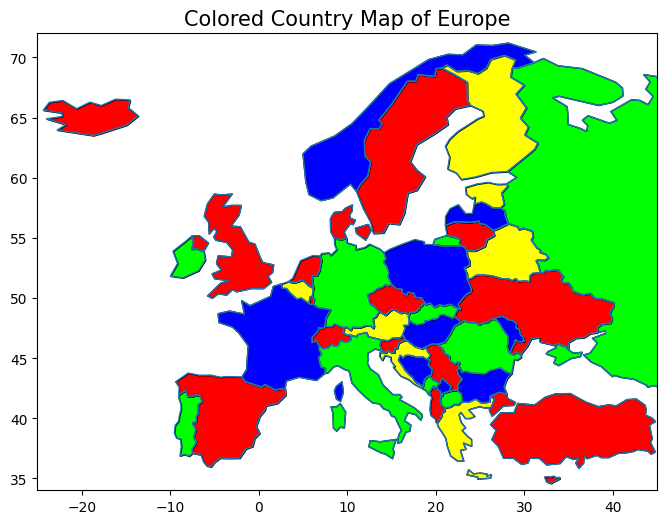

In [89]:
# no need to touch this cell, just run it after you have a solution

import geopandas as gpd
import matplotlib.pyplot as plt

rgb_colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00']
country_colors = {country: rgb_colors[colors[country]] for country in countries}

url = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"
world = gpd.read_file(url)
europe = world[world['NAME'].isin(countries)]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
europe.boundary.plot(ax=ax, linewidth=1)
for country in europe.iterrows():
    country_name = country[1]['NAME']
    color = country_colors.get(country_name, '#999999')  # Default color if not specified
    europe[europe['NAME'] == country_name].plot(ax=ax, color=color, edgecolor='black')

ax.set_xlim(-25, 45) # west-east borders of Europe
ax.set_ylim(34, 72) # south-north borders of Europe

plt.title('Colored Country Map of Europe', fontsize=15)
plt.show()

### Unsatisfiable Cores

What if we only have three colors? No big surprise, you cannot color the map of Europe with only three colors. Find the "minimal reason" why it is impossible to do so.

In satisfiability problems, the *unsatisfiable core* of an unsatisfiable set of assertions is simply a subset of all assertions that are still unsatisfiable when taken together. The unsatisfiable core is useful for understanding why a set of assertions is unsatisfiable. Therefore, we prefer unsatisfiable cores to be small. A minimal unsatisfiable core is an unsatisfiable subset of assertions such that any assertion removed from the subset makes the set satisfiable. While minimal unsatisfiable cores are the most useful, they are often difficult to find. Your task is to find a minimal unsatisfiable core for the problem of coloring the map of Europe with three colors.

Most SMT solvers can provide unsatisfiable cores, however, this feature is often disabled by default due to its computational cost. In Z3, you need to enable it explicitly. Furthermore, you also need to ask the solver explicitly to minimize the unsatisfiable core. These configuration commands are provided below to spare you the time of looking them up in the documentation.

Steps to complete the task:
* Copy the code from the previous task and modify it to allow only three colors.
* Replace the `add` method with the [`assert_and_track`](https://z3prover.github.io/api/html/classz3py_1_1_solver.html#ad1255f8f9ba8926bb04e1e2ab38c8c15) method to add and track the assertions. You will need to provide a unique name for each assertion (hint: use country names in a template string if you add assertions in a loop). An example for the usage of this method:
  ```python
  s.assert_and_track(x > 0, "x_positive")
  ```
* After the satisfiability check command, print the unsatisfiable core using the [`unsat_core`](https://z3prover.github.io/api/html/classz3py_1_1_solver.html#a369232cb024a5a0f200ad7ff58261563) method of the solver (if the problem is indeed unsatisfiable). You should be able to see a few (neighboring) countries in the core such that even that small subset of countries cannot be colored with only three colors.

In [ ]:
s = Solver()
s.set(unsat_core=True)        # enable unsat core tracking
s.set(':core.minimize', True) # ask the solver explicitly to give minimal unsat cores

# TODO: YOUR SOLUTION HERE (reuse the code from the previous task)

# Verification Exercises

SMT solvers are commonly used to model and analyse the behaviour of programs or systems. We often choose an encoding of programs in which the resulting formula is satisfiable if and only if the program can exhibit some erroneous behaviour; e.g., if an assertion can fail in the program. Since the data-types and theories provided by SMT solvers closely follow the semantics of common programming languages, the translation from programs to formulas is often relatively easy (anyone who had the - bad - luck to implement such a translation considering every special case would be eager to contradict this statement).


## Exercise 6: Translating a Straightline Program (1 point)

We want to check whether the assertion in the following (C-like) program always holds:

```
int x, y;    // Assume arbitrary initial values

x = x * x;
y = x + 1;

assert(y > 0);
```

For this, we first have to decide about the semantics of the `int` type: the type could be modelled as the unbounded set of integers in the mathematical sense, or as (signed) machine integers of some size. We can then choose the corresponding SMT theory and translate the statements of the program to formulas.

There are two standard tricks commonly applied in the translation:

1. Since the program updates the variable `x, y`, in the solver we need to declare several versions of those variables. This corresponds to a translation of the program to "single static assignment" (SSA) form.

2. The assertion in the program has to be added as a negated constraint to the solver, since we want to check whether it could happen that the assertion is violated.

Create declarations for both mathematical integers (using SMT Ints) and machine integers (using SMT BitVecs of size 32) and add the constraints of the program. Check whether the assertion can be violated with the two different models of integers. Is there a difference in the results? If so, why?

In [ ]:
math_integer_model = True

if math_integer_model:
    print('Using mathematical integers')
    # variable declarations assuming mathematical integers

    # TODO: YOUR SOLUTION HERE
else:
    print('Using 32-bit machine integers')
    # variable declarations assuming 32-bit machine integers

    # TODO: YOUR SOLUTION HERE

s = Solver()

# TODO: YOUR SOLUTION HERE

## Exercise 7: Translating a Program with Multiple Branches (1 point)

In Bounded Model Checking (BMC), the approach sketched in the previous section is generalised to programs with arbitrary control flow, bounding the number of execution steps (or loop iterations) that can be performed. Can you find a way to translate the following program to a set of constraints? The encoding should be formulated in such a way that the solver searches for an execution path violating the assertion. Let us stick to machine integers for this exercise. Note that the > operator for bit-vectors follows a signed interpretation in the Z3 Python API (so you can use it directly).

Note that a loop-free program can still have an exponential number of possible execution paths. We often prefer to use encodings that are linear in the size of the program, and let the solver handle the exploration of paths.

```
int x, y;

if (x > 0)
  y = x;
else
  y = -x;

assert(y >= 0);
```

In [ ]:
# TODO: YOUR SOLUTION HERE

Ah, the dirty magic of integer overflow!

## Exercise 8: Translating a Program with Heap (1 point)

One of the more interesting aspects when analysing programs using SMT solvers is the handling of data stored on the heap. In SMT, we often model such data using the theory of arrays. Arrays are sometimes also called _maps_ in this context, since arrays can be seen as a first-order theory of updatable functions.

First take the following simple program:

```
int *x;
assume(*x > 0);
*x = *x + 1;
assert(*x > 0);
```
Initially, we know that `x` points to a positive integer. We would like to show that incrementing the value does not affect its positivity. Let us skip the burden of machine integers for this exercise and use mathematical integers.

Since we only work with integers stored on the heap now, we can model the heap as a function from addresses to integers. Addresses can be modelled as integers, as well. Thus, we can represent the heap in the following way:

In [ ]:
def AddrSort():
  return IntSort()
def HeapSort():
  return ArraySort(AddrSort(), IntSort())

We give the solution for this simple example to help you with the next exercise. `Select` and `Store` are the functions to access and update the heap, respectively. However, you can use the more friendly array indexing syntax as well instead of `Select`.

In [ ]:
s = Solver()

h0 = Const('h0', HeapSort())  # initial heap
h1 = Const('h1', HeapSort())  # heap after increment
x  = Const('x',  AddrSort())  # address of the integer

# the initial value of the heap at address x is assumed to be positive
# h0[x] is short for Select(h0, x)
s.add(h0[x] > 0)
# the new heap is obtained by incrementing the value at address x
s.add(h1 == Store(h0, x, h0[x] + 1))
# assertion violation: the value at address x in the new heap is not positive
s.add(Not(h1[x] > 0))

print(s.check())  # unsat means the original assertion holds

Now, consider a slightly more complex program:

```
void swap(int *x, int *y) {
  *x = *x + *y;
  *y = *x - *y;
  *x = *x - *y;
}
```

Check whether the function correctly swaps the values stored at positions `*x` and `*y`. Translate the `swap` function into a set of constraints along with the requirement property.

In [ ]:
# TODO: YOUR SOLUTION HERE

Did you get an unexpected result? Where is the catch? Try to find the cause of the problem by looking at the model returned by the solver. What assumption is necessary to make the function work as expected? Add the extra constraint(s) and check the result again.

# Further Exercises, References and Other Resources

If you are done with all tasks, we recommend that you head over to [Dennis Yurichev's excellent SAT/SMT by example](https://smt.st/) collection of puzzles and exercises!

This material was prepared based on the [practical session](https://sat-smt-ar-school.gitlab.io/www/2024/schedule.html) of Philipp Rümmer (University of Regensburg & Uppsala University) at the SAT/SMT/AR Summer School, 27 June 2024.

You can find detailed introductions to SMT-LIB and to the Python APIs, among others, here:

* [The SMT-LIB website](https://smt-lib.org)
* [David Cok's SMT-LIB Tutorial](https://smtlib.github.io/jSMTLIB/SMTLIBTutorial.pdf)
* [Dennis Yurichev's SAT/SMT by example](https://smt.st/)
* [Leonardo de Moura's Z3Py Tutorial](https://scungao.github.io/mit-iap17/z3python.html)
* [Programming Z3](https://theory.stanford.edu/~nikolaj/programmingz3.html) by Nikolaj Bjørner, Leonardo de Moura, Lev Nachmanson, and Christoph Wintersteiger
* [Z3Py Namespace Reference](https://z3prover.github.io/api/html/namespacez3py.html)
